### EDA|

As the first step in solving a ML Problem, Its important to understand the data we are dealing with. So in this Notebook, we will be trying to understand our data a bit

#### What are the file types?

In [24]:
import pandas as pd
from collections import defaultdict
import os

train_df = pd.read_csv("splits/train.csv")

ext_counts = defaultdict(lambda: defaultdict(int))

for _, row in train_df.iterrows():
    ext = os.path.splitext(row['filepath'])[1].lower()
    label = row['label']
    ext_counts[label][ext] += 1

# Display as DataFrame
eda_ext = pd.DataFrame(ext_counts).fillna(0).astype(int)
print(eda_ext)

        a    b    c
.png  174  174  174
.jpg  161  161  161
.bmp  165  165  165


Lets next try to visualize few samples.

#### Visualize Random Sample


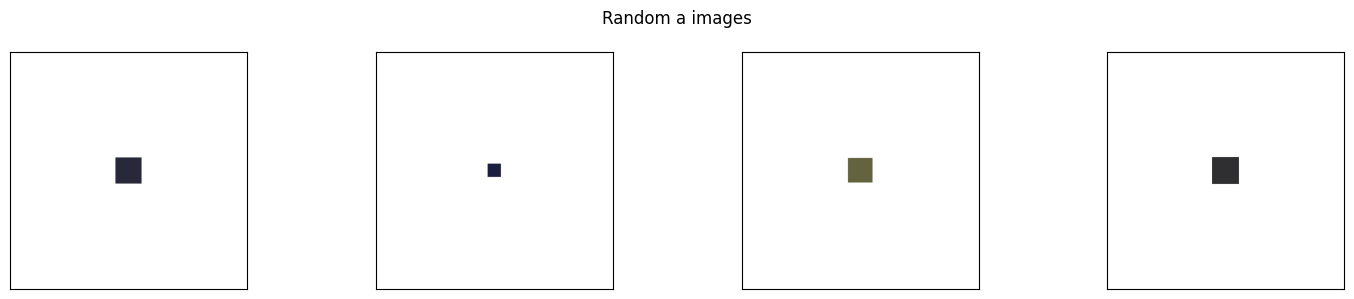

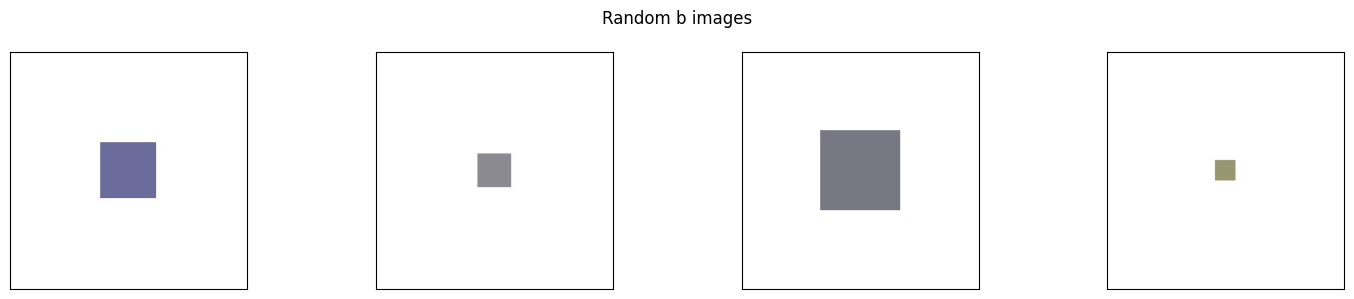

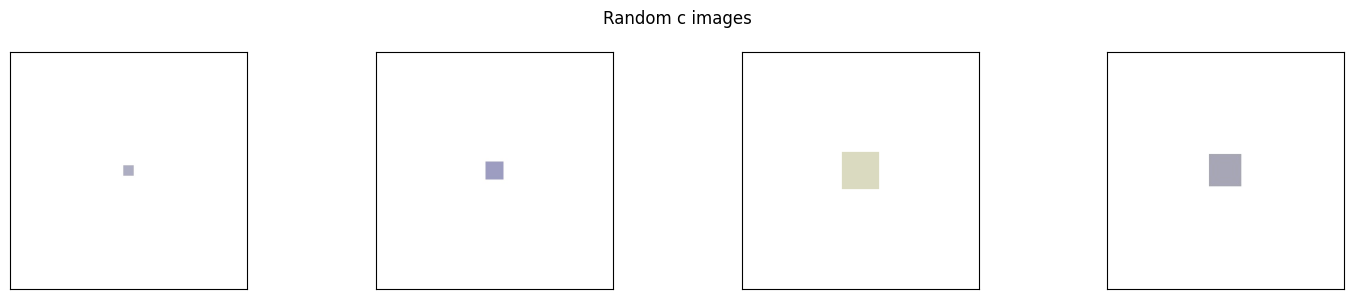

In [27]:
import random
from PIL import Image
import matplotlib.pyplot as plt

def show_random_images(df, label, count=4):
    subset = df[df["label"] == label]
    samples = subset.sample(count, random_state=42)
    plt.figure(figsize=(15, 3))
    for i, (_, row) in enumerate(samples.iterrows()):
        img = Image.open(row["filepath"]).convert("RGB")
        plt.subplot(1, count, i+1)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
    plt.suptitle(f"Random {label} images")
    plt.tight_layout()
    plt.savefig("sample_train_images_"+label+".png")
    plt.show()

for label in train_df['label'].unique():
    show_random_images(train_df, label)


#### Validating Few Observations

After looking at the images there are few things which stand out.
1. The Squares seem to be centered 
2. Do they consist of only only two colors?
3. The size of sqaure / area might matter?

#### Check if they consist of only two colors

In [35]:
import numpy as np
from PIL import Image

def only_two_colors(img_path, tolerance=10):
    img = Image.open(img_path).convert("RGB")
    img_np = np.array(img)
    h, w, _ = img_np.shape
    center = img_np[h//2, w//2]

    # Get all unique colors in the image (flattened to (N, 3))
    pixels = img_np.reshape(-1, 3)

    # helper to compare colors with tolerance
    def close(a, b):
        return np.all(np.abs(a - b) < tolerance)

    unique_colors = []
    for px in pixels:
        if not any(close(px, c) for c in unique_colors):
            unique_colors.append(px)

    #check: are all pixels either close to center or close to white?
    white = np.array([255, 255, 255])
    all_valid = all(close(c, center) or close(c, white) for c in unique_colors)

    return all_valid, len(unique_colors), center, unique_colors

# Run for a few examples
for i in range(10):
    img_path = train_df.iloc[i]["filepath"]
    is_valid, n_colors, center, colors = only_two_colors(img_path)
    print(f"{img_path} => Only two colors: {is_valid}, Unique Colors: {n_colors}, Center: {center}")


data/train/a/412.png => Only two colors: True, Unique Colors: 2, Center: [34 34 58]
data/train/a/374.png => Only two colors: True, Unique Colors: 2, Center: [83 83 64]
data/train/a/88.jpg => Only two colors: False, Unique Colors: 24, Center: [85 83 35]
data/train/a/162.png => Only two colors: True, Unique Colors: 2, Center: [73 73 81]
data/train/a/286.bmp => Only two colors: True, Unique Colors: 2, Center: [41 41 64]
data/train/a/348.jpg => Only two colors: False, Unique Colors: 21, Center: [95 94 73]
data/train/a/228.jpg => Only two colors: False, Unique Colors: 32, Center: [87 88 57]
data/train/a/200.jpg => Only two colors: False, Unique Colors: 22, Center: [100  99  78]
data/train/a/214.png => Only two colors: True, Unique Colors: 2, Center: [70 70 60]
data/train/a/32.bmp => Only two colors: True, Unique Colors: 2, Center: [29 29 82]


 Random sampling doesnt yeild concrete result, so we are going to make a fast color counter

In [17]:
import numpy as np
from PIL import Image
from collections import defaultdict
import os

def fast_unique_color_count(img_path, tolerance=0, resize=(64, 64)):
    img = Image.open(img_path).convert("RGB")
    
    if resize:
        img = img.resize(resize, resample=Image.NEAREST)  #Image.NEAREST for hard color edges
    
    img_np = np.array(img).reshape(-1, 3)

    if tolerance == 0:
        unique = np.unique(img_np, axis=0)
        return len(unique)
    else:
        quantized = (img_np // tolerance).astype(np.uint8)
        unique = np.unique(quantized, axis=0)
        return len(unique)

# Analyze per file extension
ext_color_stats = defaultdict(list)

for _, row in train_df.iterrows():
    ext = os.path.splitext(row["filepath"])[1].lower()
    n_colors = fast_unique_color_count(row["filepath"], tolerance=5)  # tweak tolerance for more speed
    ext_color_stats[ext].append(n_colors)

# Summary
for ext, colors in ext_color_stats.items():
    print(f"{ext}: Avg unique colors = {np.mean(colors):.1f}, Max = {max(colors)}, Min = {min(colors)}")



.png: Avg unique colors = 2.0, Max = 2, Min = 2
.jpg: Avg unique colors = 6.4, Max = 16, Min = 2
.bmp: Avg unique colors = 2.0, Max = 2, Min = 2


This seems to be a good find, the additional colors in jpg might due to compression

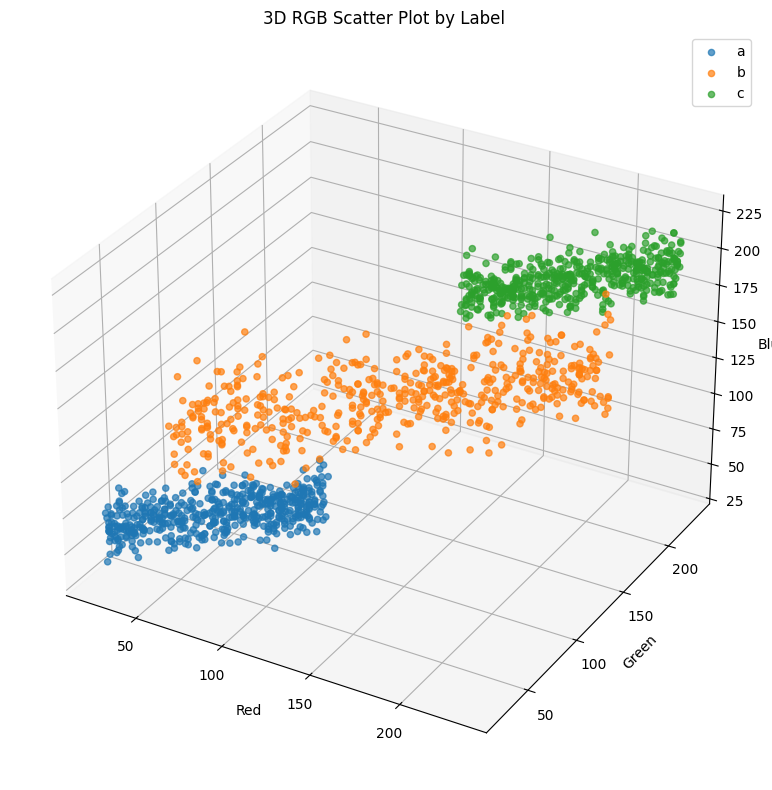

In [33]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

center_pixels = []

for _, row in train_df.iterrows():
    img = Image.open(row["filepath"]).convert("RGB")
    img_np = np.array(img)
    h, w, _ = img_np.shape
    center_rgb = img_np[h//2, w//2]
    center_pixels.append((row["label"], *center_rgb))

# Convert to DataFrame
center_df = pd.DataFrame(center_pixels, columns=["label", "R", "G", "B"])

# Plot
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for label in center_df['label'].unique():
    subset = center_df[center_df['label'] == label]
    ax.scatter(subset["R"], subset["G"], subset["B"], label=label, alpha=0.7)

ax.set_xlabel("Red")
ax.set_ylabel("Green")
ax.set_zlabel("Blue")
ax.set_title("3D RGB Scatter Plot by Label")
ax.legend()
plt.tight_layout()
plt.savefig("scatter_plot.png")
plt.show()

The center pixel RGB values almost perfectly cluster in 3D RGB space. This suggests the label is highly correlated with center color. It also implies that a lightweight model — or even a simple rule-based system — could provide a strong baseline before training complex deep nets

Does Size of square matter?

In [20]:
import numpy as np
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt

def square_area_from_image(img_path, white=np.array([255, 255, 255]), tolerance=10, resize=None):
    img = Image.open(img_path).convert("RGB")
    if resize:
        img = img.resize(resize, resample=Image.NEAREST)
    img_np = np.array(img)

    diff = np.abs(img_np - white.reshape(1, 1, 3))
    mask = (diff > tolerance).any(axis=2)  # pixels that are not "white"
    area = mask.sum()
    return area

# Compute for all training images
areas = []
for _, row in train_df.iterrows():
    area = square_area_from_image(row["filepath"], resize=(64, 64))  # resize for speed
    areas.append((row["label"], area))

area_df = pd.DataFrame(areas, columns=["label", "area"])

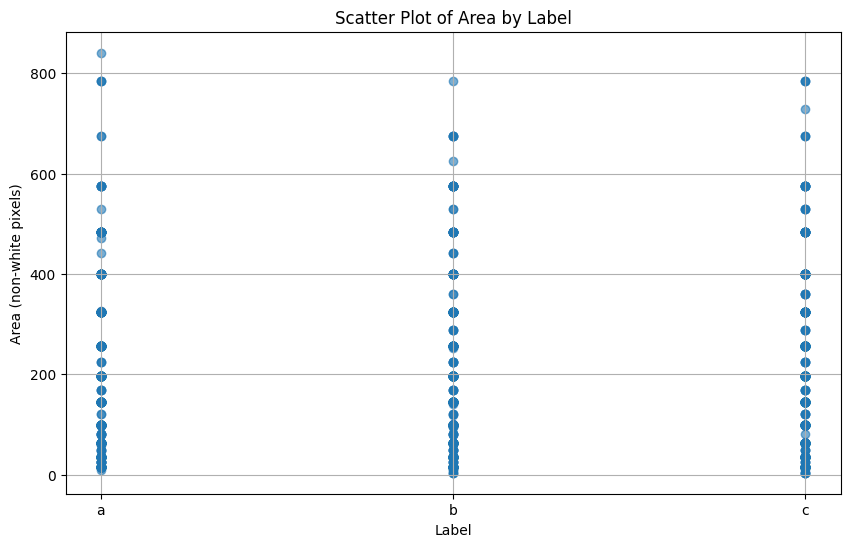

In [23]:
plt.figure(figsize=(10, 6))
label_map = {'a': 0, 'b': 1, 'c': 2}
x_vals = [label_map[l] for l in area_df["label"]]
plt.scatter(x_vals, area_df["area"], alpha=0.6)
plt.xticks(list(label_map.values()), list(label_map.keys()))
plt.xlabel("Label")
plt.ylabel("Area (non-white pixels)")
plt.title("Scatter Plot of Area by Label")
plt.grid(True)
plt.show()

The size of square doesnt seem to be a huge differtianting factor